In [1]:
import pandas as pd

import collections

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
def plot_neighbourhood(node, G, candidates, labels=False):
    # plot the neighbourhood of the top node ENSG00000101773
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]

    sub_G = nx.Graph(sub_G) # unfreeze the graph
    sub_G.remove_edges_from(nx.selfloop_edges(sub_G)) # removing self-loops

    color_map = ['orangered' if node in candidates_in_neighbourhood else 'lightblue' for node in sub_G]
    pos=nx.spring_layout(sub_G)

    plt.figure(figsize=(7, 6))
    ax = plt.gca()
    ax.set_title(f"Neighbourhood of {node}")
    nx.draw_networkx(sub_G, pos=pos, with_labels=False, node_size=100, alpha=0.9, ax=ax, node_color=color_map)

    if labels:
        # plot candidates labels
        labels = {}
        for node in sub_G.nodes():
            if node in candidates_in_neighbourhood:
                labels[node] = node

        pos_higher = {}
        for k, v in pos.items():
            if(v[1]>0):
                pos_higher[k] = (v[0]-0.1, v[1]+0.1)
            else:
                pos_higher[k] = (v[0]-0.1, v[1]-0.1)
        nx.draw_networkx_labels(sub_G, pos=pos_higher, labels=labels, font_size=10, font_color='tomato')
    
    _ = ax.axis('off')

In [16]:
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)
candidates = pd.read_pickle("./data/candidateGenesList_NOA.p")

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)
nonCandidates = [n for n in list(G.nodes) if n not in candidates]

### Analyze interactome

In [4]:
# number of proteins
len(G.nodes())

14465

In [5]:
# number of interactions
G.number_of_edges()

92064

Text(0, 0.5, 'number of nodes')

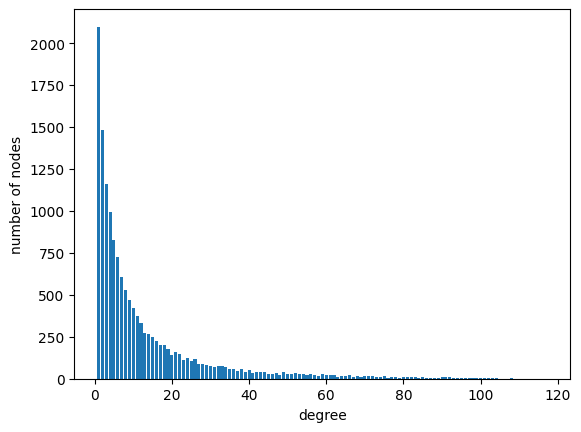

In [6]:
# degree histogram
degrees = sorted([d for n, d in G.degree()])
deg, cnt = zip(*collections.Counter(degrees).items())

plt.bar(deg, cnt)
plt.xlabel("degree")
plt.ylabel("number of nodes")

In [7]:
# average degree
sum([d for _, d in G.degree()]) / G.number_of_nodes()

12.7292084341514

### Count candidate genes for each node neighbourhood

In [8]:
# count candidate genes for each node
d = {}
d2 = {}
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)
    isCandidate = True if node in candidates else False

    d[node] = candidates_in_neighbourhood_cnt
    d2[node] = [candidates_in_neighbourhood_cnt, isCandidate]

In [9]:
s = pd.Series(d, name='# candidates in neighbourhood')
s.index.name = 'Gene'
s.reset_index()
s.sort_values(ascending=False)

Gene
ENSG00000073584    2
ENSG00000135346    2
ENSG00000139197    2
ENSG00000097007    2
ENSG00000107130    2
                  ..
ENSG00000117054    0
ENSG00000136878    0
ENSG00000172046    0
ENSG00000196177    0
ENSG00000137767    0
Name: # candidates in neighbourhood, Length: 14465, dtype: int64

In [10]:
s2 = pd.Series(d2, name='# candidates in neighbourhood')
s2.index.name = 'Gene'
s2.reset_index()
s2.sort_values(ascending=False).head(20)

Gene
ENSG00000107130    [2, False]
ENSG00000119772    [2, False]
ENSG00000117899    [2, False]
ENSG00000139197    [2, False]
ENSG00000130638    [2, False]
ENSG00000160293    [2, False]
ENSG00000132522    [2, False]
ENSG00000197299    [2, False]
ENSG00000175455    [2, False]
ENSG00000065135    [2, False]
ENSG00000166037    [2, False]
ENSG00000109685    [2, False]
ENSG00000140961    [2, False]
ENSG00000097007    [2, False]
ENSG00000135346    [2, False]
ENSG00000079277    [2, False]
ENSG00000073584    [2, False]
ENSG00000088808    [2, False]
ENSG00000142182     [1, True]
ENSG00000149311     [1, True]
Name: # candidates in neighbourhood, dtype: object

Text(0, 0.5, 'number of nodes')

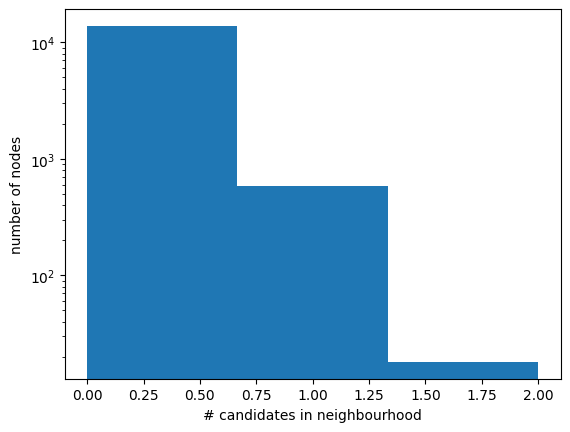

In [11]:
ax = s.plot.hist(bins=len(set(s.values)), logy=True)
ax.set_xlabel("# candidates in neighbourhood")
ax.set_ylabel("number of nodes")

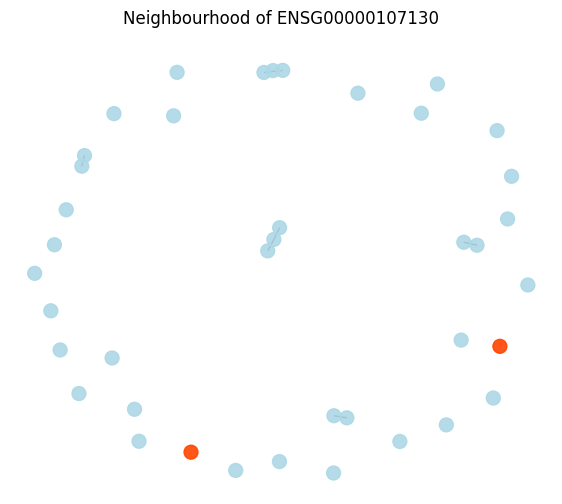

In [17]:
plot_neighbourhood("ENSG00000107130", G, candidates, labels=False)

> Information about **ENSG00000158104:**

Gene 

Protein 

In [18]:
# relation between the number of candidate genes vs degree
d = {}
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)
    d[node] = [candidates_in_neighbourhood_cnt, G.degree(node)]

df = pd.DataFrame.from_dict(d, orient='index', columns=['# candidates in neighbourhood', 'degree'])

<Axes: xlabel='degree', ylabel='# candidates in neighbourhood'>

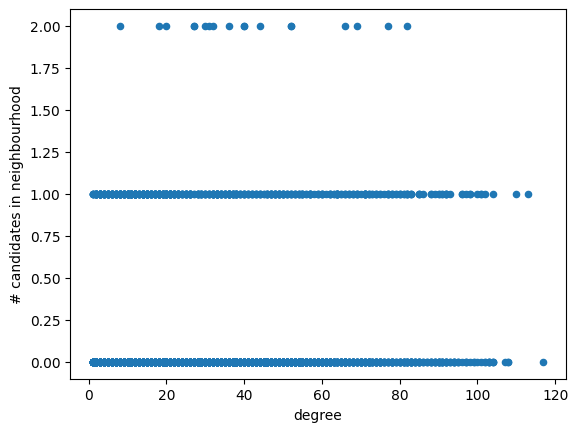

In [19]:
df.plot.scatter(x='degree', y='# candidates in neighbourhood')

In [20]:
# fraction of candidates that are present in interactome
len([candidate for candidate in candidates if candidate in G.nodes()]) / len(candidates)

# ~50% means that the second half of candidate genes has been filtered out during the building of interactome (e.g. because they form hubs >120 connections)

0.7407407407407407

In [21]:
# average degree of infertility candidate genes
d = {}

for node in G.nodes():
    if node in candidates:
        d[node] = G.degree(node)

sum([deg for n, deg in d.items()]) / len(d.keys())

15.65

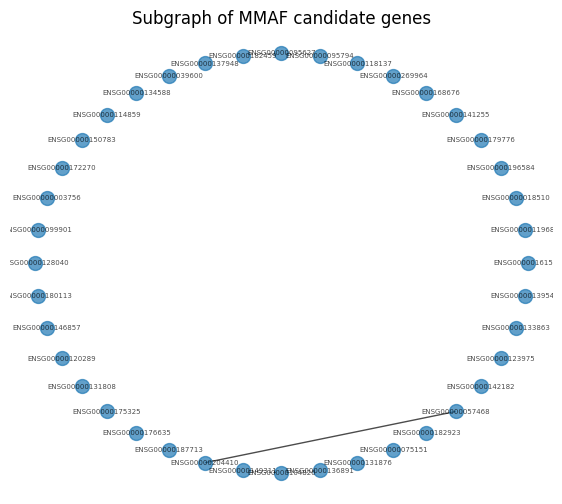

In [22]:
# subgraph of candidate genes
candidates_sub_G = G.subgraph([n for n in G.nodes() if n in candidates])

candidates_sub_G = nx.Graph(candidates_sub_G) # unfreeze the graph
candidates_sub_G.remove_edges_from(nx.selfloop_edges(candidates_sub_G)) # removing self-loops

plt.figure(figsize=(7, 6))
ax = plt.gca()
ax.set_title(f"Subgraph of MMAF candidate genes")
# nx.draw_networkx(candidates_sub_G, with_labels=False, node_size=100, alpha=0.9, ax=ax)
nx.draw_circular(candidates_sub_G, with_labels=True, node_size=100, alpha=0.7, ax=ax, font_size=5)
_ = ax.axis('off')

In [23]:
# number of nodes and edges in subgraph of candidate genes
candidates_sub_G = G.subgraph([n for n in G.nodes() if n in candidates])
candidates_sub_G.number_of_nodes(), candidates_sub_G.number_of_edges()

(40, 6)

### Score 1: Count candidate genes for each node and divide by node degree

In [24]:
# count candidate genes for each node and divide by node degree
d = {}
d2 = {}
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)
    isCandidate = True if node in candidates else False
    score = candidates_in_neighbourhood_cnt / G.degree(node)
    
    d[node] = score
    d2[node] = [score, isCandidate, G.degree(node), candidates_in_neighbourhood_cnt]

In [25]:
s = pd.Series(d, name='Score 1')
s.index.name = 'Gene'
s.reset_index()
s.sort_values(ascending=False)

Gene
ENSG00000118849    1.0
ENSG00000213398    1.0
ENSG00000197885    1.0
ENSG00000182308    1.0
ENSG00000183324    1.0
                  ... 
ENSG00000117054    0.0
ENSG00000136878    0.0
ENSG00000172046    0.0
ENSG00000196177    0.0
ENSG00000137767    0.0
Name: Score 1, Length: 14465, dtype: float64

In [26]:
s2 = pd.Series(d2, name='Score 1')
s2.index.name = 'Gene'
s2.reset_index()
s2.sort_values(ascending=False)

Gene
ENSG00000213398    [1.0, False, 1, 1]
ENSG00000183324    [1.0, False, 1, 1]
ENSG00000182308    [1.0, False, 1, 1]
ENSG00000197885    [1.0, False, 1, 1]
ENSG00000118849    [1.0, False, 1, 1]
                          ...        
ENSG00000187775    [0.0, False, 1, 0]
ENSG00000240204    [0.0, False, 1, 0]
ENSG00000174946    [0.0, False, 1, 0]
ENSG00000156486    [0.0, False, 1, 0]
ENSG00000102935    [0.0, False, 1, 0]
Name: Score 1, Length: 14465, dtype: object

> Information about **ENSG00000205922:**

Gene ONECUT3

Protein O60422 *One cut domain family member 3* (**Transcriptional activator for HNF3B** -- early development; its expression emerges in the primitive streak and node at embryonic day (E) 6.5, and in the mesoderm and definitive endoderm at E7.5. and **TTR** (e.g. transports thyroid hormones in the plasma and cerebrospinal fluid))

Text(0, 0.5, 'number of nodes')

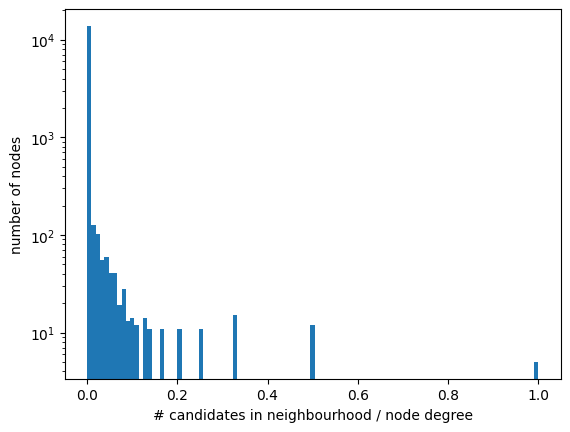

In [27]:
ax = s.plot.hist(bins=len(set(s.values)), logy=True)
# ax = s[s>0].plot.hist(bins=len(set(s.values)))
ax.set_xlabel("# candidates in neighbourhood / node degree")
ax.set_ylabel("number of nodes")

### Score 2: Harmonic centrality

In [28]:
res = nx.harmonic_centrality(G, nbunch=nonCandidates, sources=candidates)

In [29]:
res_sorted = dict(sorted(res.items(), key=lambda v: v[1], reverse=True))

In [30]:
res_sorted

{'ENSG00000170365': 15.166666666666671,
 'ENSG00000097007': 14.783333333333337,
 'ENSG00000163513': 14.666666666666673,
 'ENSG00000099956': 14.66666666666667,
 'ENSG00000170312': 14.500000000000002,
 'ENSG00000066427': 14.416666666666668,
 'ENSG00000117475': 14.366666666666669,
 'ENSG00000008735': 14.333333333333337,
 'ENSG00000044115': 14.333333333333337,
 'ENSG00000112062': 14.333333333333336,
 'ENSG00000185811': 14.333333333333336,
 'ENSG00000120693': 14.333333333333336,
 'ENSG00000160293': 14.31666666666667,
 'ENSG00000107130': 14.300000000000002,
 'ENSG00000067369': 14.283333333333337,
 'ENSG00000170004': 14.283333333333337,
 'ENSG00000117899': 14.250000000000004,
 'ENSG00000139197': 14.233333333333334,
 'ENSG00000197102': 14.200000000000005,
 'ENSG00000229809': 14.200000000000001,
 'ENSG00000072062': 14.166666666666673,
 'ENSG00000137098': 14.166666666666671,
 'ENSG00000005102': 14.166666666666671,
 'ENSG00000198890': 14.16666666666667,
 'ENSG00000183137': 14.16666666666667,
 'EN